I used a Reddit dataset from Kaggle to perform clustering analysis and classification on comments from different subreddits. The dataset consists of 25,000 comments, score, and controversiality for each of the 40 most frequented subreddits as of May 2019. The dataset contains a total of 1 million comments.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Kaggle dataset from Google Drive
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Reddit_Kaggle.zip')

# Subset of subreddits to use; try these 6 subreddits after experimenting on the whole dataset
#df = df[df.subreddit.isin(['worldnews', 'gonewild', 'gameofthrones', 'soccer', 'hockey', 'dankmemes'])]

In [ ]:
df

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1
...,...,...,...,...
999995,Pikabu,И ла и нет. Если жопа будет слишком сзади поте...,0,1
999996,Pikabu,"Исходя из этого, я тогда 3 раза все лайки инте...",0,2
999997,Pikabu,Человек из лиги ЛГБТ поди и не раз...,0,1
999998,Pikabu,"С Пикабу ушел,не для того что бы скрины читать",0,-5


# Data Exploration

In [ ]:
# Import libraries
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Exploration

In [ ]:
## Find most common word in each subreddit

# Separate list of words by space and make it a list

def top_words(df):
  comment = df['body']
  lowercase = comment.str.lower()
  wordlist = lowercase.str.split(' ').explode()
  # Remove stopwords from list
  rid_stopwords = wordlist[wordlist.map(lambda word: word not in stop_words and word != '')]
  wordcounts = rid_stopwords.value_counts()
  topwords = wordcounts.head(100).index.tolist()
  return topwords

df.sample(frac=0.01).groupby('subreddit').apply(top_words)

subreddit
AmItheAsshole          [like, would, get, even, think, people, sex, o...
Animemes               [like, anime, |, get, people, would, still, ev...
AskReddit              [like, people, know, post, get, got, never, wo...
ChapoTrapHouse         [like, people, would, shit, one, really, sex, ...
FortNiteBR             [game, like, people, please, season, post, act...
Market76               [[^(**|**, =, set, +, ^(bids/offers.), ign, 2,...
MortalKombat           [get, like, one, game, people, even, know, see...
Pikabu                 [и, не, в, а, что, на, -, это, я, как, с, но, ...
RoastMe                [like, look, know, one, get, would, people, lo...
Showerthoughts         [please, like, also, class, submission, modera...
SquaredCircle          [like, people, would, one, know, he's, get, wa...
The_Donald             [like, one, would, still, get, think, trump, n...
apexlegends            [like, game, get, people, would, apex, think, ...
asoiaf                 [would, like, one,

We are starting to see some unique words in each subreddit, but there's still a lot of overlap of words between the subreddits.

In [ ]:
# Find average length of each subreddit

# Write function to calculate length of the comment

def average_num_words(df):
  comment = df['body']
  lowercase = comment.str.lower()
  num_words = lowercase.str.split(' ').map(len)
  return num_words.mean()

df.groupby('subreddit').apply(average_num_words).sort_values(ascending=False)

subreddit
relationship_advice    56.90732
AmItheAsshole          55.80336
asoiaf                 53.74456
gameofthrones          43.60692
worldnews              43.49980
unpopularopinion       41.90540
news                   38.56672
politics               34.93256
freefolk               34.10000
movies                 33.81048
videos                 33.53252
marvelstudios          32.99508
AskReddit              32.93820
apexlegends            31.69552
memes                  31.52772
leagueoflegends        31.11332
todayilearned          30.06136
Showerthoughts         28.79256
nfl                    27.78368
ChapoTrapHouse         27.63724
dankmemes              26.65676
FortNiteBR             25.30796
MortalKombat           25.19868
SquaredCircle          25.16776
soccer                 25.04104
trashy                 23.86468
The_Donald             23.78684
gaming                 23.72848
pics                   23.58580
Market76               23.47068
hockey                 19.9763

Most subreddits have an average word count of 20-30 words. 

# Training the Model

In [ ]:
# Split the data into Train-Test Function
import numpy as np
from sklearn.model_selection import train_test_split

X = df['body'].values
y = df['subreddit'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer,
                                             TfidfTransformer)
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline([
        ('count_vectorized', CountVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')),           
        ('tfidf_transformer', TfidfTransformer(smooth_idf=True, use_idf=True)),
        # Test different models

        #('clf', LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')),
        #('clf', SVC(kernel='sigmoid')),
        #('clf', RandomForestClassifier(max_depth=20, random_state=0)),
        ('clf', MultinomialNB(alpha=0.1)),
])

# Train the model
full_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('count_vectorized',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

# Test the Model

In [ ]:
# Test the model
y_pred = full_pipeline.predict(X_test) # predicted subreddits

# Accuracy
np.mean(y_pred == y_test) # returns a vector of trues/falses

0.48199

# Display Confusion Matrix

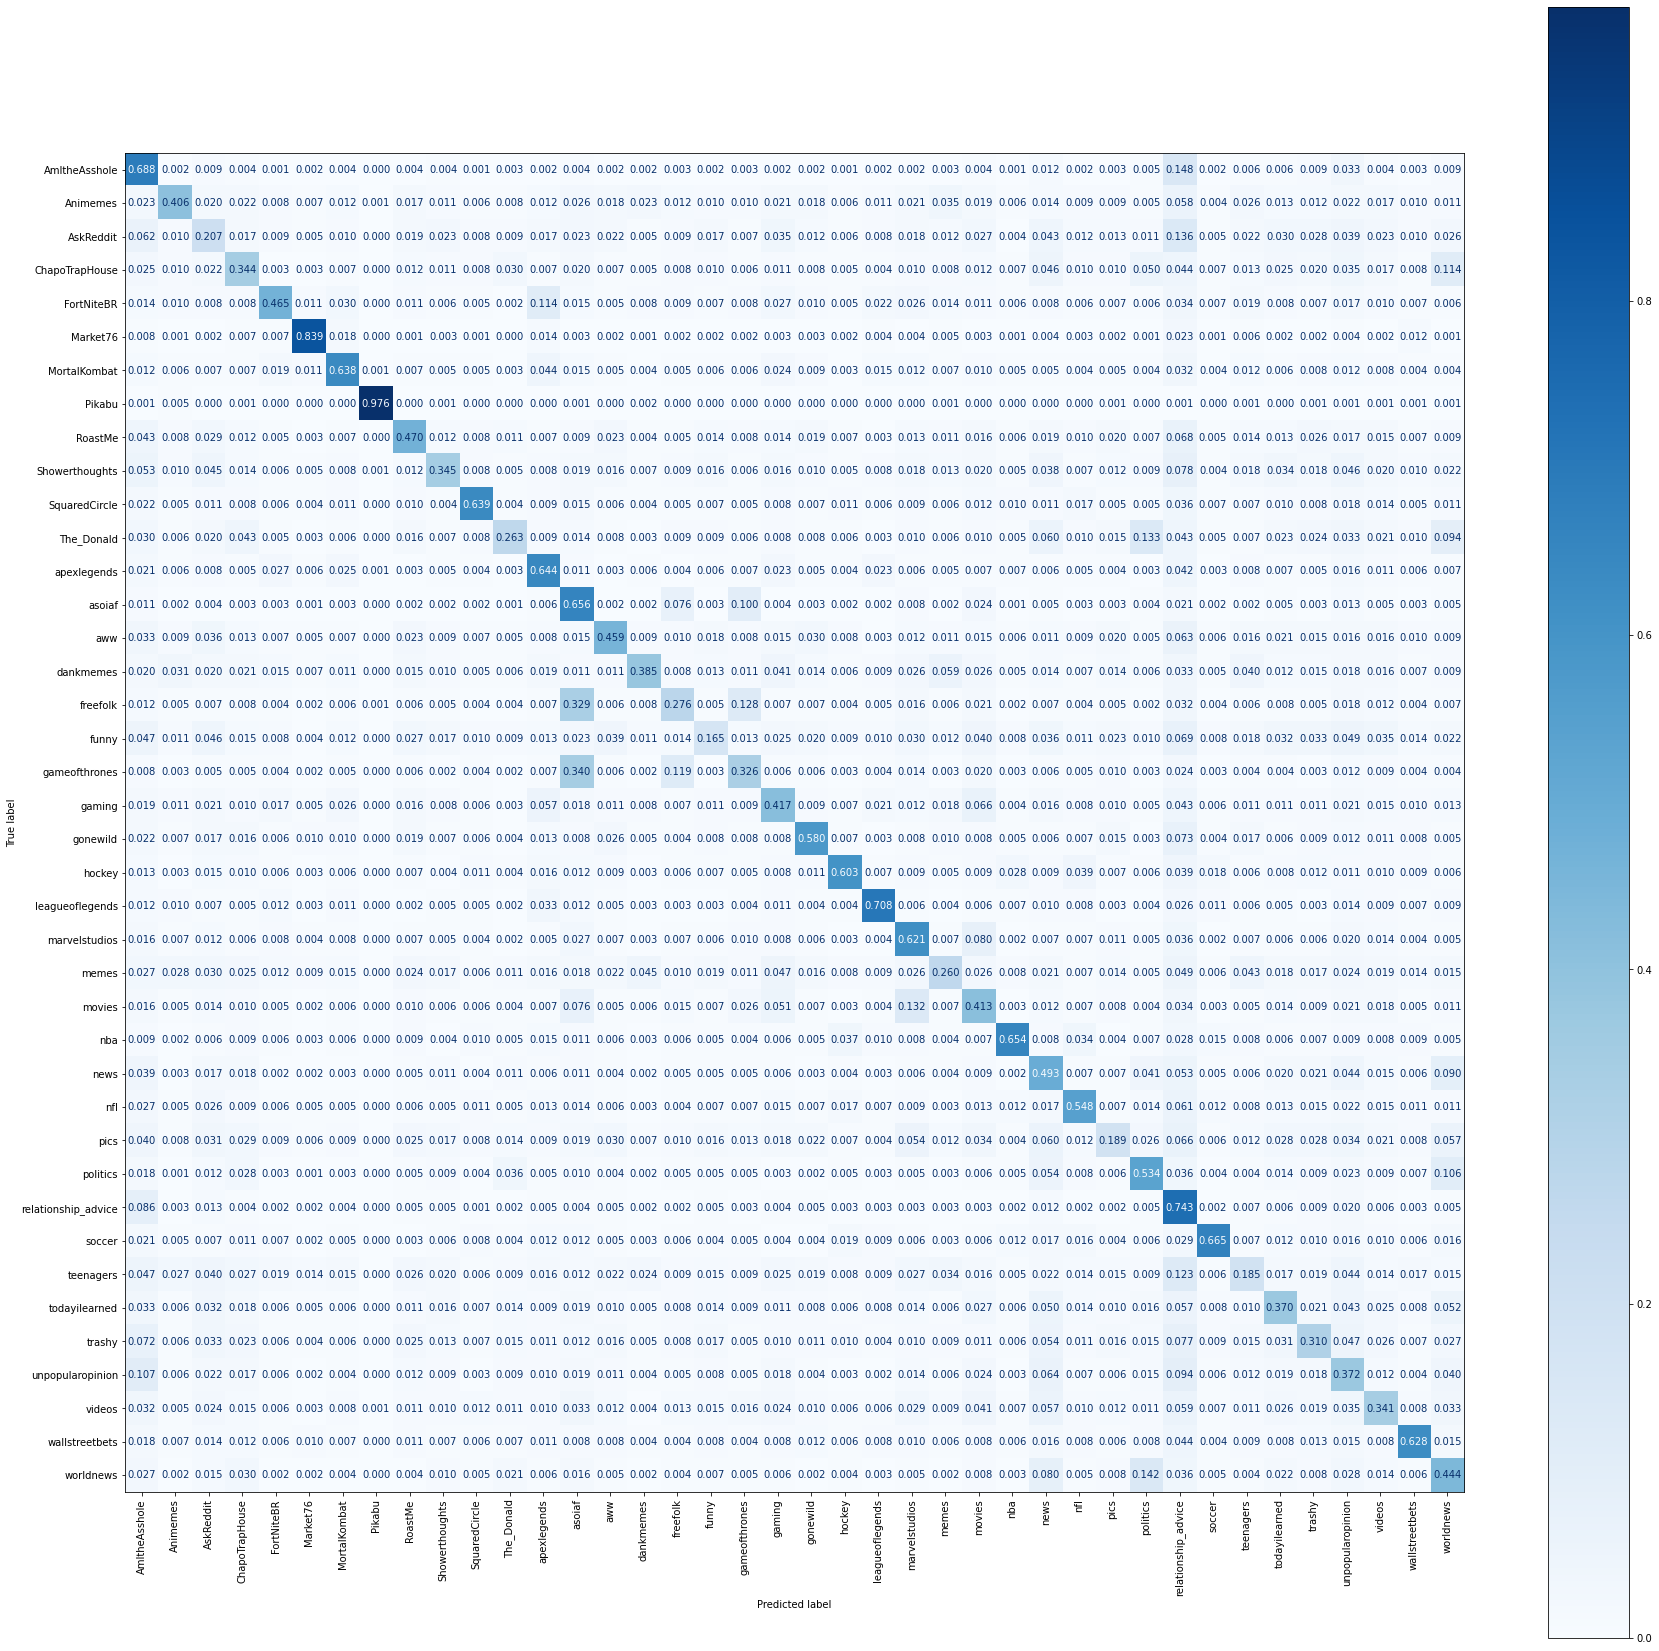

In [ ]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(30,30))
disp = plot_confusion_matrix(
    full_pipeline,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    ax=ax,
    normalize='true',
    xticks_rotation='vertical',
    values_format='.3f'
)
plt.show()

# Clustering Analysis

In [ ]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=50)
cluster_pipeline = Pipeline([
        ('count_vectorized', CountVectorizer(analyzer='word', ngram_range=(1, 1))),           
        ('tfidf_transformer', TfidfTransformer(smooth_idf=True, use_idf=True)),
        ('clf', k_means)                         
    ])

# Train the model
cluster_pipeline.fit(X_train[:10000])

Pipeline(memory=None,
         steps=[('count_vectorized',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_i

## Data Exploration on Clusters

In [ ]:
cluster_pipeline.predict(X_train[:100])

array([25, 31, 12, 29, 49, 21, 30, 11, 47, 12, 30, 27,  9, 27, 35,  3, 18,
       27, 29, 32, 30,  4, 23, 46, 49, 29, 14, 26, 27, 49, 27,  8, 35, 30,
       32,  9, 37, 43, 27,  7, 41, 49, 27, 30, 18, 22, 36, 48, 20, 14, 29,
        3, 19, 34, 22, 11, 27, 24,  9, 13,  1,  1,  9, 47, 29, 21, 32, 19,
       49, 21, 23, 44, 27, 43, 36, 29, 33, 23, 38, 29, 33, 28, 27, 48,  0,
       34, 29, 12, 33, 42, 23, 30, 46,  9, 34, 27, 10, 30, 18, 29],
      dtype=int32)

In [ ]:
# Make two new columns in the dataframe
cluster_df = pd.DataFrame()
cluster_df['cluster'] = cluster_pipeline.predict(X_train)
cluster_df['subreddit'] = y_train
cluster_df['body'] = X_train

cluster_df.head(10)

,cluster,subreddit,body
0,25,gaming,I agree completely!\n\nCould it have been bett...
1,31,gonewild,I love that ass too
2,12,funny,Guys give better massages. This is a known fac...
3,29,apexlegends,It updated for me. Ps4
4,49,nfl,Reading this title made me feel like I was hav...
5,21,news,Someone repost this to r/hypocrite for some ka...
6,30,unpopularopinion,Average of 45 per day out of 350 million. 7 ze...
7,11,dankmemes,"Finally something dank, subs been flooded with..."
8,47,dankmemes,That's what I call ground beef
9,12,Animemes,Yeah they kinda have. But I'm still gonna watc...


In [ ]:
# Counting percentage of subreddit per cluster 
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
clusters = cluster_df.groupby('cluster')['subreddit'].apply(lambda x: x.value_counts() / len(x)).to_frame()
clusters

subreddit
cluster                               
0       gonewild              0.053058
        aww                   0.037916
        wallstreetbets        0.032670
        Animemes              0.032312
        teenagers             0.031716
        MortalKombat          0.031239
        funny                 0.031120
        FortNiteBR            0.030166
        memes                 0.029927
        nfl                   0.029927
        marvelstudios         0.028496
        nba                   0.027781
        hockey                0.027662
        apexlegends           0.027423
        leagueoflegends       0.026827
        gaming                0.026350
        pics                  0.026350
        RoastMe               0.025873
        videos                0.025277
        trashy                0.025039
        freefolk              0.024800
        gameofthrones         0.024085
        SquaredCircle         0.023966
        todayilearned         0.023727
        Showerthoughts        0.023489
        movies                0.023489
        dankmemes             0.023370
        AskReddit             0.023250
        soccer                0.022893
        The_Donald            0.022535
        ChapoTrapHouse        0.021700
        unpopularopinion      0.020269
        politics              0.019316
        asoiaf                0.018958
        AmItheAsshole         0.017408
        news                  0.017169
        worldnews             0.015142
        relationship_advice   0.014308
        Market76              0.012281
        Pikabu                0.000715
1       news                  0.043417
        gonewild              0.041892
        unpopularopinion      0.040366
        aww                   0.035535
        RoastMe               0.035026
        worldnews             0.034518
        trashy                0.034200
        pics                  0.033310
        Showerthoughts        0.033119
        The_Donald            0.032547
        nba                   0.031403
        todayilearned         0.031022
        ChapoTrapHouse        0.029559
        soccer                0.028987
        wallstreetbets        0.027780
        teenagers             0.026000
        funny                 0.025618
        leagueoflegends       0.025300
        Animemes              0.024474
        apexlegends           0.024093
        politics              0.023520
        videos                0.022567
        AmItheAsshole         0.022503
        hockey                0.021804
        gaming                0.021613
        FortNiteBR            0.020342
        AskReddit             0.020342
        MortalKombat          0.020278
        Market76              0.019770
        nfl                   0.019706
        movies                0.019007
        SquaredCircle         0.018626
        memes                 0.018562
        freefolk              0.018054
        dankmemes             0.017926
        relationship_advice   0.017799
        gameofthrones         0.013095
        asoiaf                0.012777
        marvelstudios         0.012777
        Pikabu                0.000763
2       gonewild              0.051411
        Animemes              0.047335
        pics                  0.046708
        FortNiteBR            0.040752
        funny                 0.040752
        MortalKombat          0.038245
        memes                 0.037931
        aww                   0.033856
        RoastMe               0.033856
        teenagers             0.032602
        gaming                0.031975
        trashy                0.031348
        marvelstudios         0.030721
        todayilearned         0.029467
        Showerthoughts        0.028840
        wallstreetbets        0.027586
        news                  0.026332
        freefolk              0.026019
        dankmemes             0.025705
        apexlegends           0.025078
        ChapoTrapHouse        0.023197
        The_

In [ ]:
# Look into Cluster 1 more closely and see what kind of subreddits and comments are in there
cluster_df[cluster_df.cluster == 1].head(10)

,cluster,subreddit,body
60,1,Showerthoughts,"I thought about it and this is wrong. \nI have a .0000001 chance to win the lottery \nThere are only 2 options \nWin or lose\n But I’ll get a million Ls before I get a W\n\nI get a surgery it has 99.999 chance to survive\nThere’s two options\nI survive or die \nThere’s not a 50% chance I die \n\n\nYou are dumb \nNow this is 100% chance of being true\nThere’s no other option\nSo I’m sorry, but..."
61,1,wallstreetbets,You are right. I am wrong. Okay. \n\n\n\n-\nPs. Look up actuarial science / financial modeling / and use a real broker
169,1,funny,Those pants are a little baggy.
191,1,wallstreetbets,How big are you down?
282,1,todayilearned,"I mean unless you are paving highways in which major delays for work time traffic would occur, paving during the day is fine"
297,1,FortNiteBR,because their bots? are you being serious right now?
310,1,trashy,Are you Polish though?
350,1,SquaredCircle,So that's why NXT matches are 5 star classics? Who would've thought
405,1,unpopularopinion,Weed can be psychologically addictive tho. I know people who are addicted personally.\n\nEdit: words
447,1,AmItheAsshole,"Google cortisol and stress hormones. They absolutely are a real thing that absolutely are altered during and after a serious injury - like a badly broken leg requiring surgery.\n\nEdit: [here ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1342721/) is the very first peer-reviewed article google spat out when I put in the search, showing how stress hormones are elevated after trauma\n\nEdit 2:..."


In [ ]:
cluster_df.groupby('cluster').apply(top_words).sort_values(ascending=False)

cluster
27    [и, не, в, на, что, like, а, -, я, это, с, как, i'm, would, good, но, get, у, так, по, people, то, got, если, ты, все, love, за, go, still, lol, i’m, fucking, think, из, там, бы, even, же, also, он, hog, ну, see, right, never, уже, только, time, для, от, make, want, вот, 2, know, или, every, don’t, просто, new, could, к, есть, меня, тут, shit, look, &gt;, need, someone, pretty, они, да, day, b...
25    [yes, yes,, yes., yes!, ah, like, would, i'm, people, one, good, that's, get, oh, well, actually, right, think, also, it’s, i’m, love, know, please, it., say, still, see, need, even, sure, no., much, said, make, want, thank, time, that’s, fucking, lol, really, hell, got, go, never, mean, is., could, first, -, every, take, look, great, way, definitely, fuck, post, always, point, someone, commen...
24    [yeah, yeah,, like, yeah., that's, oh, would, i'm, get, people, pretty, think, one, good, really, got, it’s, lol, see, know, well, hell, still, i’m, that’s, sure, even, defin

# PCA Plot of Cluster Centers

In [ ]:
# Extract cluster centers into PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(k_means.cluster_centers_)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

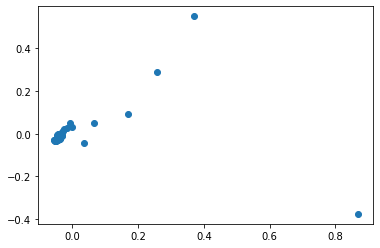

In [ ]:
X_pca = pca.transform(k_means.cluster_centers_)
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.show()

# Conclusions
Overall, this dataset is a difficult to train models on well because of the sheer volume of data. The dataset has 1 million comments in 40 different subreddits. Second, many of the subreddits have similar content, so it could be difficult to classify between the subreddits. For the full dataset, naive bayes proved to be the best model for both the full dataset and got a test accuracy of 48%. SVM and Logistic Regression timed out, perhaps because there was too much data. The PCA plot showed that the clustering analysis showed that there were many clusters that were able to be clustered together, save for a few outliers. 

Because of the similarities of many of the subreddits, I wanted to see how the accuracy would change if only a select few subreddits were chosen. I chose to do a much smaller dataset of only 6 subreddits, each one showing different content. I decided to leave 'soccer' and 'hockey' in there to see if the model can still classify between 2 similar subreddits.